In [176]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
%%time

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}


num_timesteps = 24 * 7
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}

initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    #     speculators # folks speculating on clover coin price
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f90874be710>]


In [181]:
%%time

def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        substep = row['substep']
        run = row['run']
        s = row['s']
        g = s['network']
        new_cols = {}

        
        miners = utils.get_nodes_by_type(s, 'miner')
        clovers = utils.get_nodes_by_type(s, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward

        new_cols['miners'] = len(miners)
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(s['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)

# adding new useful columns for graphing
full_df['coin-price'] = utils.calculateCurrentPrice(
    (full_df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (full_df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

full_df['market-cap'] = full_df['coin-price'] * full_df['bc-totalSupply'] * 250


full_df

CPU times: user 272 ms, sys: 7.94 ms, total: 280 ms
Wall time: 280 ms


In [182]:
df = full_df[full_df['substep'] == len(partial_state_update_blocks)] # after player policy

df

,bank,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,miners,players,reward-rotSym,reward-x0Sym,...,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price,market-cap
3,100,128,40.006320,30349.386691,131,131,34,66,1.433333,0.921429,...,8,1,3,1,13,50,48,9,0.001680,12748.731947
6,100,254,40.006320,30406.052726,257,257,34,66,1.953846,1.058333,...,12,1,3,2,23,94,102,22,0.001680,12766.985278
9,100,383,39.976590,30443.614880,389,389,34,66,2.270588,1.245161,...,16,1,3,3,30,157,142,40,0.001678,12773.872240
12,100,518,39.853693,30415.810914,534,534,34,66,2.650000,1.261905,...,19,1,3,4,41,207,204,58,0.001676,12743.429770
15,100,646,39.654703,30365.824187,664,664,34,66,2.357143,1.157895,...,27,1,3,5,56,256,250,70,0.001672,12692.601801
18,100,779,39.627434,30399.219990,803,803,34,66,2.484375,1.169118,...,31,1,3,6,67,323,288,85,0.001671,12698.538923
21,100,911,39.550282,30415.679288,935,935,34,66,2.426316,1.152500,...,37,1,3,7,79,376,335,94,0.001669,12690.315641
24,100,1043,39.416836,30403.608160,1068,1068,34,66,2.397727,1.146739,...,43,1,3,8,91,429,380,111,0.001666,12663.118412
27,100,1172,39.372073,30427.671028,1202,1202,34,66,2.472917,1.141346,...,47,1,3,9,103,493,418,125,0.001665,12662.970336
30,100,1297,39.258752,30421.223963,1327,1327,34,66,2.517308,1.109322,...,51,1,3,10,117,548,453,139,0.001662,12641.088509


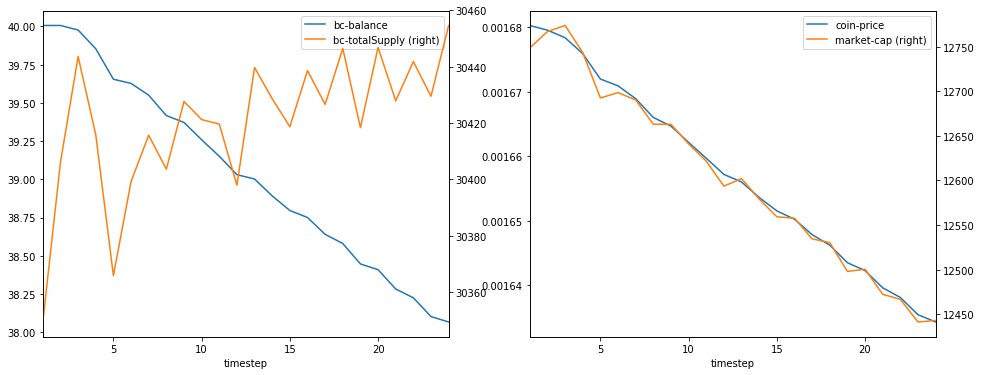

In [183]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[run,1])

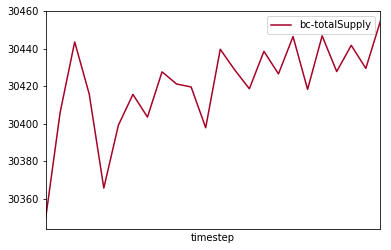

In [184]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn',
       )

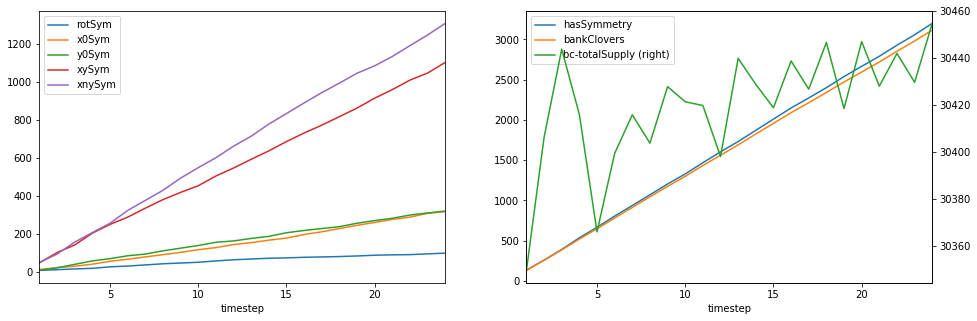

In [185]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

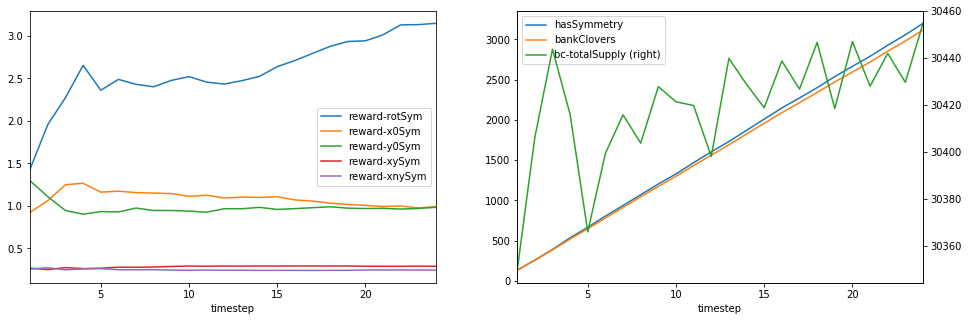

In [186]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

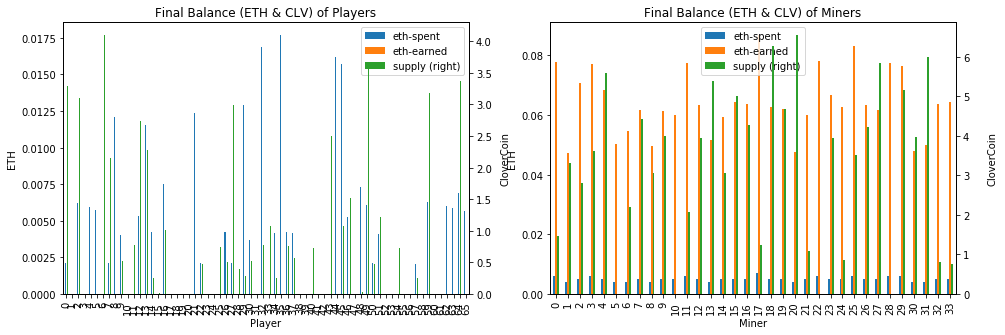

In [189]:
final_state = raw_result[-1]['s']
g = final_state['network']
miners = utils.get_nodes_by_type(final_state, 'miner')
players = utils.get_nodes_by_type(final_state, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(16,(row_height*num_runs)))
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if num_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if num_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
        pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])

Text(0.5, 51.0, 'Timestep')

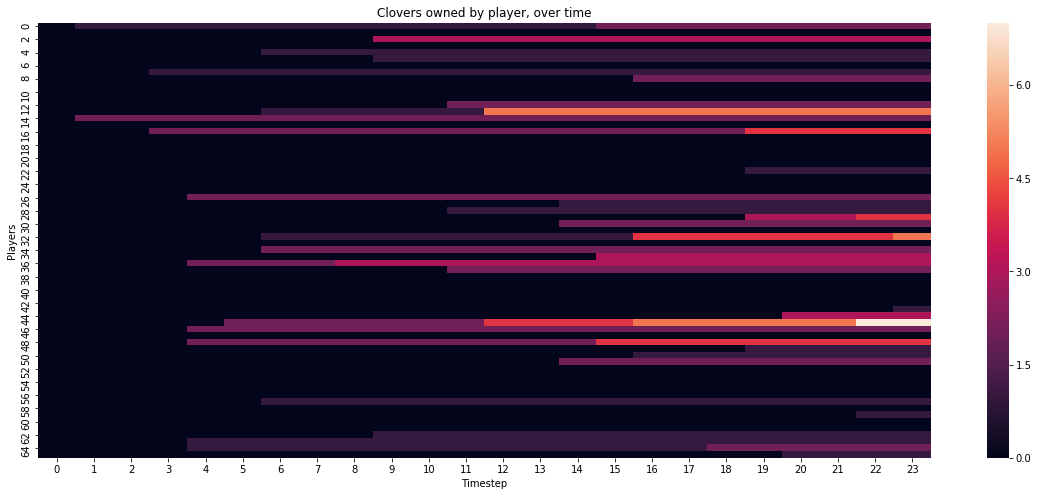

In [191]:
players = utils.get_nodes_by_type(raw_result[1]['s'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = len(list(g.successors(i_ind)))

dims = (20, 8)
# adjust the dimensions

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

Text(0.5, 24.0, 'Timestep')

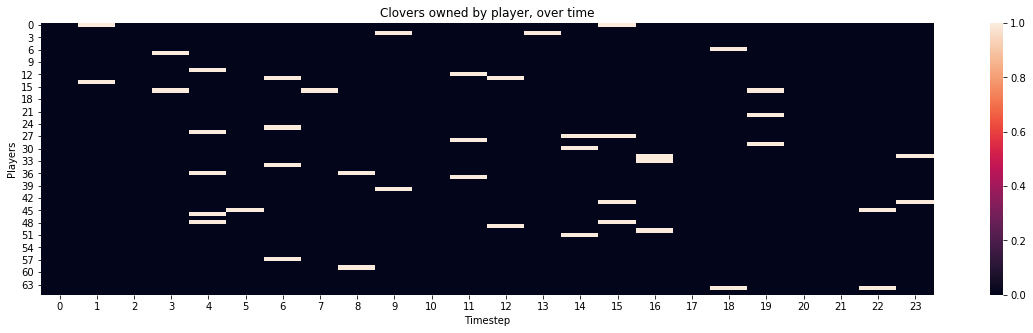

In [192]:
players = utils.get_nodes_by_type(raw_result[1]['s'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = g.nodes[i_ind]['is_active']

dims = (20, 5)

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

In [86]:
#raw_result

In [193]:



pdf

,cash_out_threshold,eth-earned,eth-spent,hashrate,is_active,supply,type
0,0.01,0.077720,0.006072,15.539548,0.7,1.455165,miner
1,0.01,0.047412,0.004048,12.529845,0.7,3.312018,miner
2,0.01,0.070868,0.005060,14.496620,0.7,2.802225,miner
3,0.01,0.077187,0.006072,15.628832,0.7,3.620676,miner
4,0.01,0.068277,0.005060,13.104511,0.7,5.590180,miner
5,0.01,0.050405,0.004048,12.031441,0.7,0.000000,miner
6,0.01,0.054576,0.004048,11.623610,0.7,2.191976,miner
7,0.01,0.061775,0.005060,14.132321,0.7,4.412415,miner
8,0.01,0.049680,0.004048,13.187791,0.7,3.045972,miner
9,0.01,0.061372,0.005060,16.381317,0.7,3.999031,miner


In [195]:
s = raw_result[10]['s']
g = s['network']
clovers = utils.get_nodes_by_type(s, 'clover')

g.nodes[clovers[5]]

p = g.nodes[clovers[5]]

In [196]:
p['newField'] = 23

In [197]:
p

{'type': 'clover',
 'reward': 0.23333333333333336,
 'price': 3.3333333333333335,
 'step': 1,
 'rotSym': False,
 'y0Sym': False,
 'x0Sym': False,
 'xySym': False,
 'xnySym': True,
 'pretty': 1.8506152163632752,
 'hasSymmetry': True,
 'owner_type': 'bank',
 'newField': 23}

In [198]:
g.nodes[5]

{'type': 'player',
 'hashrate': 17.809220233327643,
 'player_active_percent': 0.7,
 'supply': 0,
 'eth-spent': 0,
 'eth-earned': 0,
 'desired_for_sale_ratio': 0.760273751700373,
 'market_buying_propensity': 0.19022806858384567,
 'is_active': False}

In [199]:
import networkx as nx
g = nx.DiGraph()

for i in range(5):
    g.add_node(i)
    
g.add_edge(2,3)
g.add_edge(1,3)
g.add_edge(1,2)
print("original edges:")
for i in g.edges():
    print(i)

ebunch = list(g.edges(1))
g.remove_edges_from(ebunch)
    
print("new edges:")
for i in g.edges():
    print(i)

original edges:
(1, 3)
(1, 2)
(2, 3)
new edges:
(2, 3)


In [200]:
ebunch = g.edges(1)

g.remove_edges_from(ebunch)

In [201]:
g.edges(1)

OutEdgeDataView([])

In [202]:
from numpy.random import rand
import numpy as np
from scipy.stats import norm

cloverObjValue = 0
stdDev = 1
playerId = 20
cloverId = 5
np.random.seed([playerId,cloverId])
norm.rvs(loc=cloverObjValue,scale=stdDev)

-0.3875415218651566

In [203]:
rand()

0.9282891790029177

In [204]:
raw_result[30]

{'s': {'bc-balance': 39.258751584166575,
  'bc-totalSupply': 30421.22396329922,
  'symmetries': {'hasSymmetry': 1327,
   'rotSym': 51,
   'y0Sym': 139,
   'x0Sym': 117,
   'xySym': 453,
   'xnySym': 548},
  'network': <networkx.classes.digraph.DiGraph at 0x7f88c2177d30>,
  'players': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65],
  'miners': [66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99],
  'bank': 100,


In [205]:
def test_function():
    step = 30
    s = raw_result[step]

    _input = policies.miner_policy([params], step, None, s)
    s['s'] = state_updates.update_state_miner_policy(None, step, None, s, _input)[1]

    _input = policies.player_policy([params], step, None, s)
    s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    
    _input = policies.market_activity_policy([params], step, None, s)
    s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    return s


# %lprun -f utils.processBuysAndSells test_function()
%lprun -f policies.miner_policy \
-f state_updates.update_state_miner_policy \
-f state_updates.processCloverIntentions \
-f state_updates.utils.processBuysAndSells \
test_function()

In [33]:
foo = {'me': 2}

if 'me' in foo:
    print(1)

1
